# OPENCLASSROMS - PARCOURS DATA SCIENTIST

## Projet 7 - Implémentez un modèle de scoring

**Notebook illustratif des fonctions du fichier src/train.py**

**Dans le repértoire src, se trouve le fichier train.py, dans lequel sont implémentées 3 fonctions principales:**

In [1]:
#Librairies de manipulation des données
import pandas as pd
import numpy as np
import codecs #permet de d'importer des fichier html sous la forme de données textuelles - utile pour le DataDrift

#Libraires de gestion système
import os
os.chdir('..')
import warnings
import sys
import gc
import mlflow
import json

#Librairies de visualisation des données
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import chi2_contingency


#Librairies relatives aux modèles (pour accès à la liste de leurs hyperparamètres dans notre cas, et shap pour interprétation locale)
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import shap

#Mise en mémoire du chemin absolu du fichier actuel
script_path = os.getcwd()

#Ajout du folder src pour l'import des fonctions de nos différents fichiers
sys.path.append('src')
sys.path.append('input')
warnings.filterwarnings("ignore")
os.chdir('src')
#Importation des fonctions des fichiers src/train.py et src/utils.py
from utils import correlation_lister
from utils import Quantitative_Distribution_Plotter
from utils import Qualitative_Distribution_Plotter
from train import import_data
from train import pkl_import
from train import hyperparam_tuning
from train import smote_hyperparam_tuning
from utils import experiments_lister
from utils import run_lister
from utils import run_metrics
from utils import del_run
from utils import del_experiment
from utils import runs_plotter
from utils import cv_results_returner
os.chdir('..')

*NB : Certaines fonctions importées ici proviennent du fichier src/utils.py, et ont été crée dans le but de nettoyer, visualiser, lels données ou encore gérer le stockage de certains fichiers.*

*Leur fonctionnemet est décrit directement dans le fichier src/utils.py.*

*Par exemple, la fonction chi2_dropper sert à comparer les features des jeux de données d'entraîenemt à nos targets, et à supprimer les features qualitatifs trop corrélés à la target suivant le critère du chi2.*

*Un autre exemple est la fonction correlation_dropper, qui va supprimer certains features numériques trop corrélés entre elles au sein de notre jeu de données.*

**Ces fonctions ont pour objectif d'améliorer la modélisation par l'amélioration de la qualité des jeux de données!**


In [2]:
'''Dans ce fichier, nous allons définir plusieurs fonctions permettant de crée nos expériences et nos runs via mlflow.

Dans ce cadre, nous définirons des fonctions permettant de crée une épxerience, entraînent un premier traitement des données
initailes à notre disposition, de manière à créer plusieurs jeux de données, pour l'entraînement, la mise en production, et les targets.

Par la suite au sein de chaque expérience, nous allons mettre en place des runs au sein desquels nous mettons en places des fonctions permattant
d'entraîner des modèles, avec une recherche sur grille des meilleurs hyper-paramètres, la mesure des performances des modèles en utilisat plusieurs métriques, 
et la centralisation des modèles et de différents artéfacts de manière centralisée en utilisant mlflow tracking.'''

#Impotration des libriries utiles

#fonction de feature engineering issue du kernel Kaggle
from FeatureEngineering import main

#Librairies de destion système
import gc
import os
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from joblib import dump
from joblib import load
import json

#Librairies de manipulation des données
import numpy as np
import pandas as pd

#Librairies de visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

#Librairires de pré-processing des données
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.compose import make_column_selector
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

#Librairies d'importation des modèles
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklego.meta import Thresholder #non utilisée ici, mais a servie au développement

#Librairies de mesure de performances (métriques)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import make_scorer #mise en place d'un score métier 
from sklearn.inspection import permutation_importance

#Fonctions définies dans le fichier utils.py 
from utils import nan_dropper #suppression features avec des valeurs manquantes à partir d'un certain seuil
from utils import Correlation_filter
from utils import nan_filler
from utils import eta_squared_dropper
from utils import std_dropper
from utils import chi2_dropper

#Définiton de notre loss function pour séléctionner les meilleurs modèles en terme de coût métier
def fn_fp_scorer(y_true, y_pred):
    '''Dans notre cas, la classe positive correspond au fait qu'un crédit s'est retrouvé en défaut de paiement.
    C'est également la classe minoritaire de notre jeu de données.
    Nous estimerons ici (ce qui est à préciser pour un cas d'application réel), qu'un client en défaut de paiement
    coûte 10 fois plus que ce qu'aurait rapporté un crédit refusé qui ne se serait pas retrouvé en défaut de paiement.
    Nous avons donc une fonction coût qui pénalise 10 fois plus les faux négatifs que les faux positifs.
    Nous pondéront cette loss à la taille de la population pour consérver des valeurs comparables en test, validation et à 
    l'entraînement.'''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = -(10*fn + fp)/len(y_true)
    return score

#Définition du score à partir de la loss function
model_score = make_scorer(fn_fp_scorer, greater_is_better=True)

# 1- Traitement des données - fonction *'import_data'*

## 1.1- Définition des arguments de la fonction

**Les arguments sont les suivants:**

*NB: Les seuils de corrélation à la target sont fixés dans l'aplication de manière à éviter le data leakage, et ne sont pas paramètrables par l'utilisateur.*

In [3]:
#Définition des inputs de la fonction import_data du fichier ../src/train.py

pickle_export = True
nan_thresh = 0.08
corr_thresh = 0.65
nan_strategy = 'median'
exp_name = 'PROJECT_7_OC_DS_EXPERIENCE_REFERENCE'

In [4]:
#Description de notre expérience

exp_desc = "Expérience de référence pour notre projet!\nCette expérience nous permettra de travailler avec un jeux de données pour lequel nous supprimons les variables ayant plus de 18% de valeurs manquantes à l'entraînement, et complète les valeurs manquantes par la médiane de la colonne pour les variables quantitatives.\nNotons que les valeurs manquantes des variables qualitatives sont One-Hot-Encoded comme étant une catégorie à part entière, seuls les variables numériques sont donc impactées.\nEnfin, pour les variables numériques, nous sélectionnons les variables pour lesquels nous avons un coefficient de Pearson supérieur à 0.65 en valeur absolue."

In [5]:
#Définition du repértoire de stockage des expériences

mlflow.set_tracking_uri('mlruns')

#Définition du nom de l'expérience par l'utilisateur et création de l'expérience via mlflow
EXPERIMENT_NAME = exp_name
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME, tags = {'Description' : exp_desc})
EXP_DICT = {'ID': str(EXPERIMENT_ID), 'NAME' : EXPERIMENT_NAME}
os.chdir('src')

#Appel de la fonction main pour effectuer notre feature engineering à partir du kernel kaggle
df = main(debug = False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 45s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 62s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 35s
Installments payments df shape: (339587, 26)
Process installments payments - done in 51s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 40s


In [6]:
#Séparation des jeux de données train, de production (test), et les targets
train_index = df.loc[~df['TARGET'].isna()].index
train = df.loc[~df['TARGET'].isna()]
test = df.loc[df['TARGET'].isna()]
target = pd.DataFrame(train['TARGET'])

#Suppression des colonnes inutiles - et redéfinition des jeux de données train et production
df = df.drop(['TARGET', 'index', 'SK_ID_CURR'], axis = 1)
train = df.loc[df.index.isin(train_index)]
test = df.loc[~df.index.isin(train_index)]

## 1.2- Suppression des colonnes trop vides et avec une variance trop faible

*NB : Les features qualitatifs étants One-Hot-Encoded, elles ont des valeurs binaires (soit 0 soit 1). Dans le cas de ces variables, supprimer les features avec une variance trop faible revient à supprimer les features pour lesquels nous avons une modalité trop similaire.*

Text(0, 0.1, 'Seuil maximal de valeurs manquantes toléré')

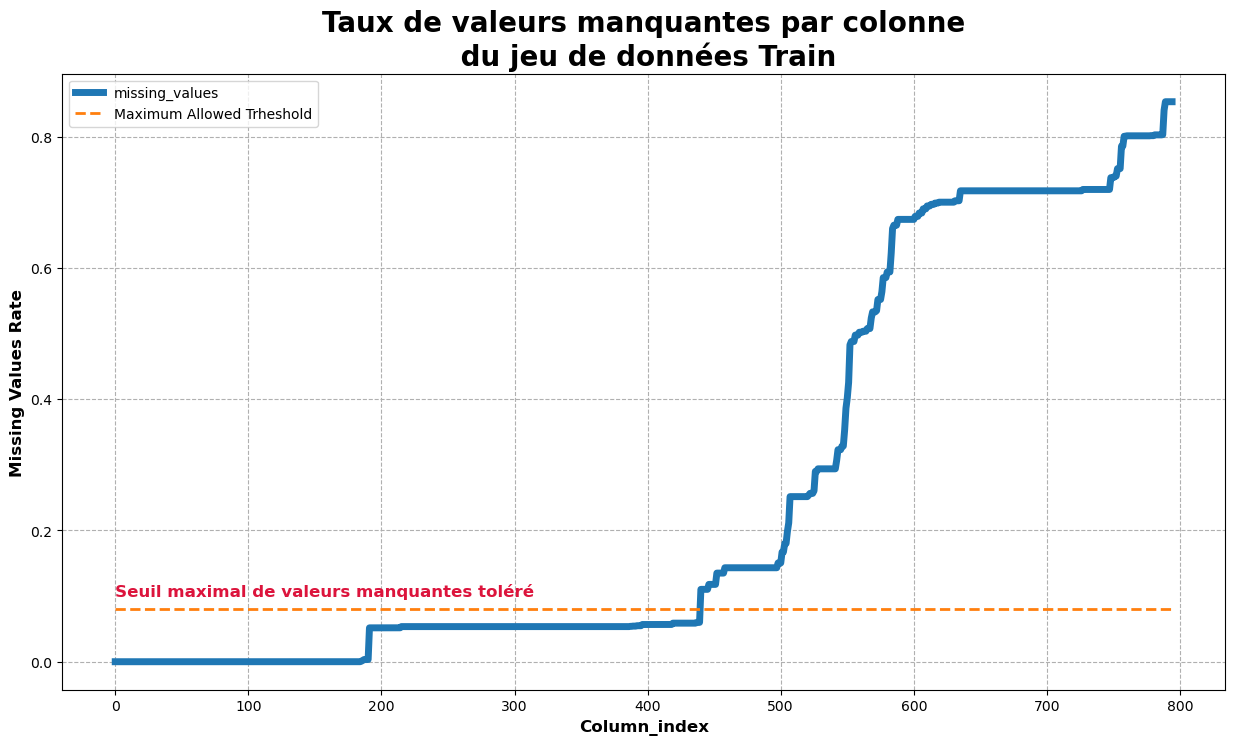

In [7]:
#Affichage des valeurs manquantes par colonne

missing_values = train.isna().mean().sort_values()

plt.figure(figsize = (15,8))
plt.rcParams.update({'font.size' : 10})
plt.title('Taux de valeurs manquantes par colonne\n du jeu de données Train', size = 20, weight = 'bold')
plt.plot(range(len(train.columns)), missing_values, label = 'missing_values', lw = 5)
plt.plot(range(len(train.columns)), np.linspace(nan_thresh,nan_thresh, len(train.columns)), ls = '--', lw = 2, label = 'Maximum Allowed Trheshold')
plt.xlabel('Column_index', size = 12, weight = 'bold')
plt.ylabel('Missing Values Rate', size = 12, weight = 'bold')
plt.legend(loc='upper left')
plt.grid(True, ls = '--')
plt.text(0, nan_thresh + 0.02, 'Seuil maximal de valeurs manquantes toléré', size = 12, weight = 'bold', color = 'crimson')

In [8]:
#Filtre des features via les seuils sur les valeurs manqauntes, les coefficients de pearson et complétion des valeurs manquantes
train = nan_dropper(train, nan_thresh)
test = test[train.columns]
train = nan_filler(train, 'median')

for i in train.columns:
    test[i] = test[i].fillna(train[i].median())

In [9]:
#Variance des différentes colonnes

std_list = []
for i in train.columns:
    std_list.append(train[i].std())
std_df = pd.DataFrame({'columns' : train.columns, 'Std' : std_list}).sort_values(by = 'Std')

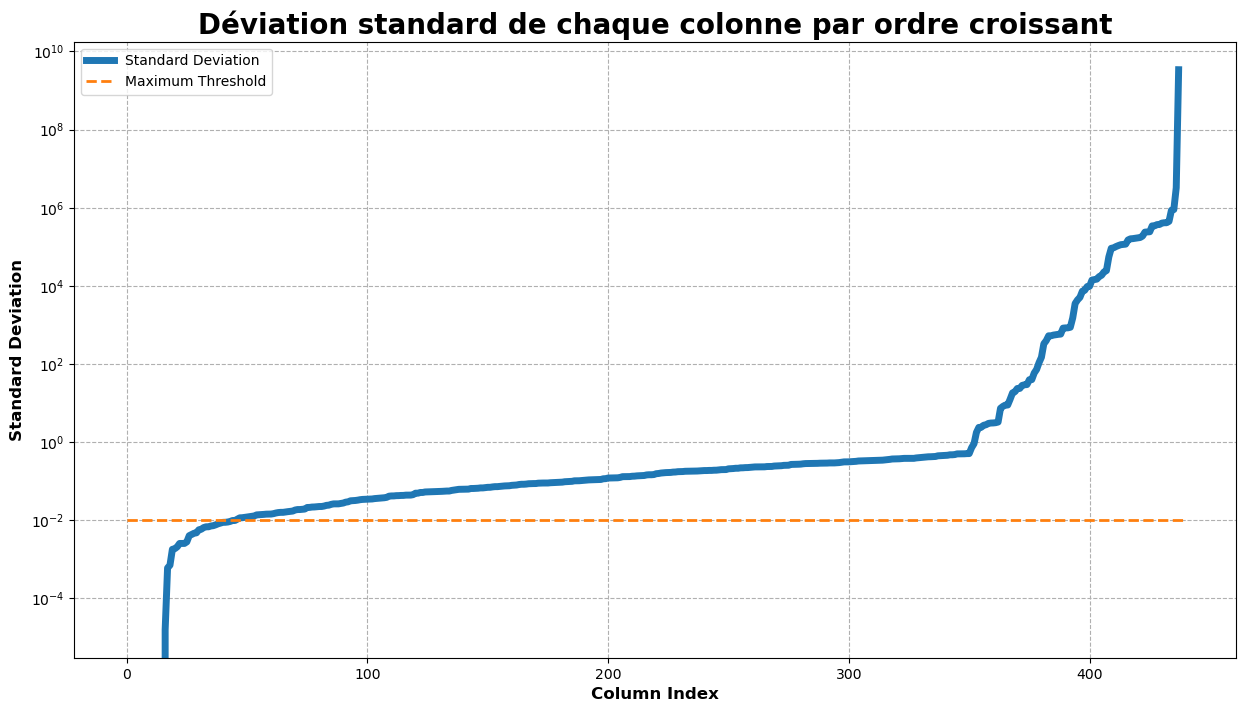

In [10]:
#Affichage des déviations standards des colonnes

plt.figure(figsize = (15,8))
plt.rcParams.update({'font.size' : 10})
plt.title('Déviation standard de chaque colonne par ordre croissant', size = 20, weight = 'bold')
plt.plot(range(len(train.columns)), std_df['Std'].values, lw = 5, label = 'Standard Deviation')
plt.plot(range(len(train.columns)), np.linspace(0.01, 0.01, len(train.columns)), lw = 2, ls = '--', label = 'Maximum Threshold')
plt.legend(loc = 'upper left')
plt.yscale('log')
plt.xlabel('Column Index', size = 12, weight = 'bold')
plt.ylabel('Standard Deviation', size = 12, weight = 'bold')
plt.grid(True, ls = '--')

In [11]:
#Suppression des features pour lesquelles on manque de variance

train = std_dropper(train, 0.01)
test = test[train.columns]

## 1.3- Suppression des features trop corrélés à la target

In [12]:
#On place les colonnes qualitatives (one-hot-encodées dans le kernel kaggle - moins de 3 valeurs uniques) en type object
for i in train.columns:
    if len(train[i].unique()) < 3:
        train[i] = train[i].astype(object)
        test[i] = test[i].astype(object)

In [13]:
#Masks sur les différents types de colonnes
cat_cols = train.dtypes.loc[train.dtypes == 'object'].index
num_cols = train.dtypes.loc[train.dtypes != 'object'].index

#Projectionsur les colonnes catégoriques
train_cat = train[cat_cols]

#Filtre sur les colonnes qualitatives trop corrélées à la target - critère du chi2
p_values = []
for i in train_cat.columns:
    table = pd.crosstab(train_cat[i], target['TARGET'])
    results_test = chi2_contingency(table)
    p_values.append(results_test[1])
    
p_values_df = pd.DataFrame({'cols' : train_cat.columns, 'p_value' : p_values}).sort_values(by = 'p_value', ascending = True)

<AxesSubplot:title={'center':'Exemple de feature qualitatif\n trop corrélé à la target'}, xlabel='TARGET', ylabel='ORGANIZATION_TYPE_Advertising'>

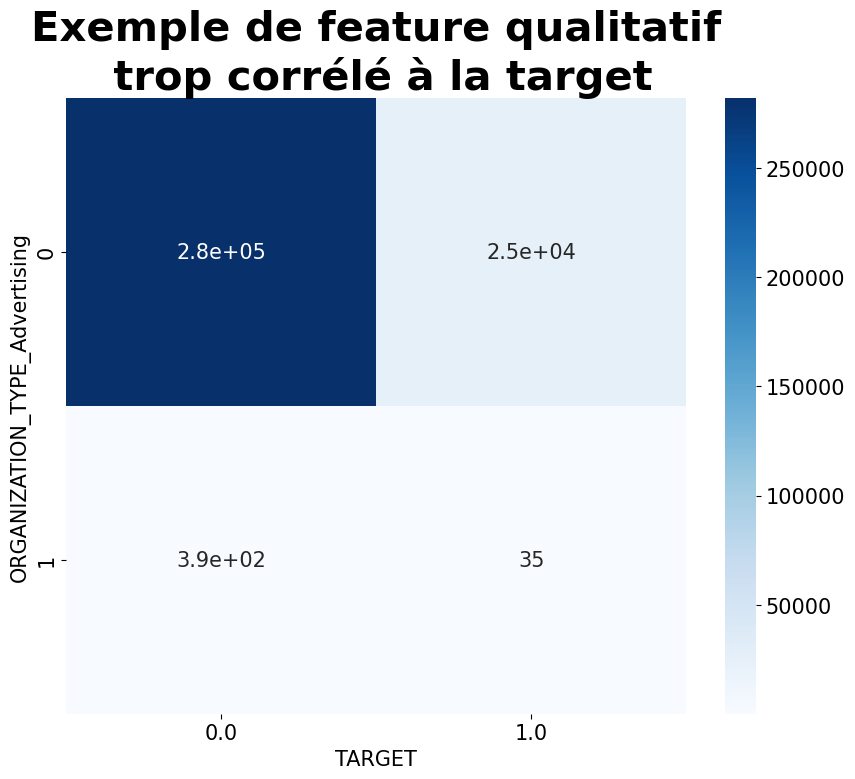

In [14]:
#Exemple de feature catégorique trop corrélé à la target

exemple = p_values_df.loc[p_values_df['p_value'] == 1, 'cols'].values[0]
table = pd.crosstab(train_cat[exemple], target['TARGET'])

plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size' : 15})
plt.title('Exemple de feature qualitatif\n trop corrélé à la target', size = 30, weight = 'bold')
sns.heatmap(table, cmap = 'Blues', annot = table)

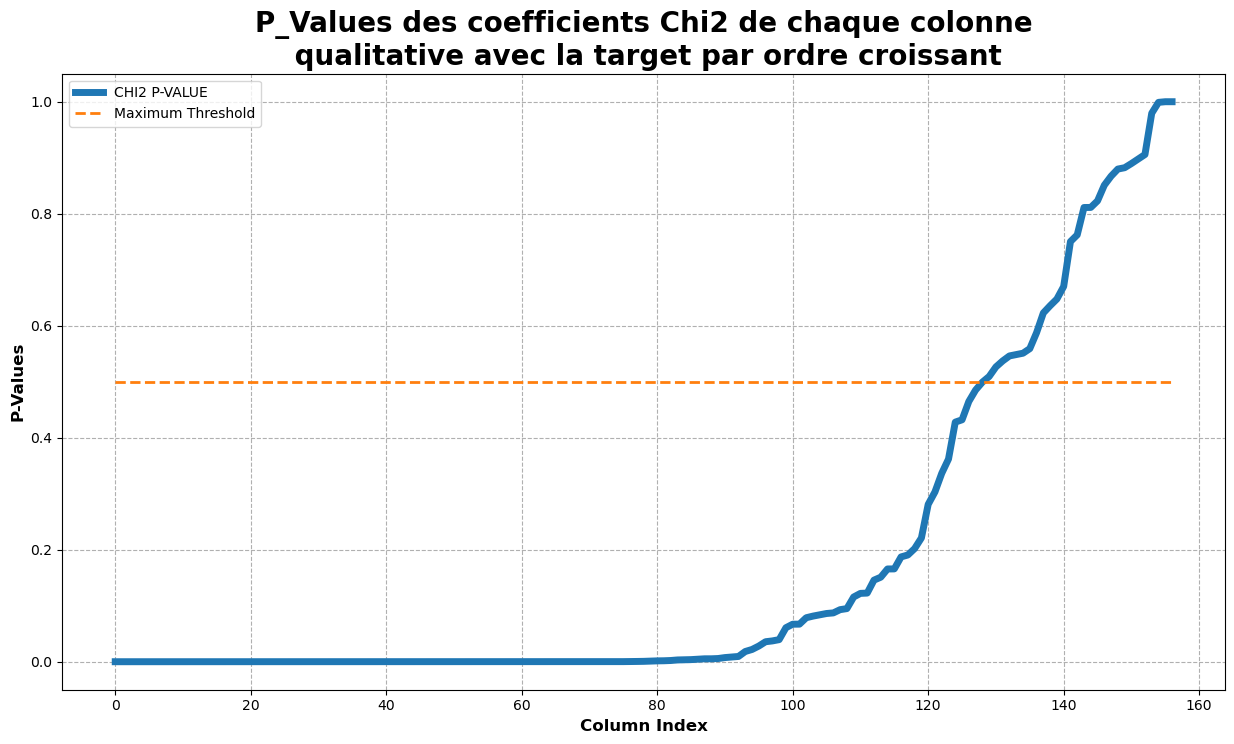

In [15]:
#Affichage des p_values des coefficients chi2 entre les variabes catégoriques et la target

plt.figure(figsize = (15,8))
plt.rcParams.update({'font.size' : 10})
plt.title('P_Values des coefficients Chi2 de chaque colonne\n qualitative avec la target par ordre croissant', size = 20, weight = 'bold')
plt.plot(range(len(train_cat.columns)), p_values_df['p_value'].values, lw = 5, label = 'CHI2 P-VALUE')
plt.plot(range(len(train_cat.columns)), np.linspace(0.5, 0.5, len(train_cat.columns)), lw = 2, ls = '--', label = 'Maximum Threshold')
plt.legend(loc = 'upper left')
plt.xlabel('Column Index', size = 12, weight = 'bold')
plt.ylabel('P-Values', size = 12, weight = 'bold')
plt.grid(True, ls = '--')

In [16]:
#Suppression des 30 colonnes trop corrélées à la target

train = chi2_dropper(train, target, 0.5)
test = test[train.columns]

In [17]:
#Nous réalisons la même opération avec les variables quantitatives, en se servant de la métrique eta_squared

train = eta_squared_dropper(train, target, 0.5)
test = test[train.columns]

## 1.4- Suppression des features trop corrélé entre elles

In [18]:
#Masks sur les différents types de colonnes
cat_cols = train.dtypes.loc[train.dtypes == 'object'].index
num_cols = train.dtypes.loc[train.dtypes != 'object'].index

#Projectionsur les colonnes catégoriques
train_cat = train[cat_cols]
train_num = train[num_cols]

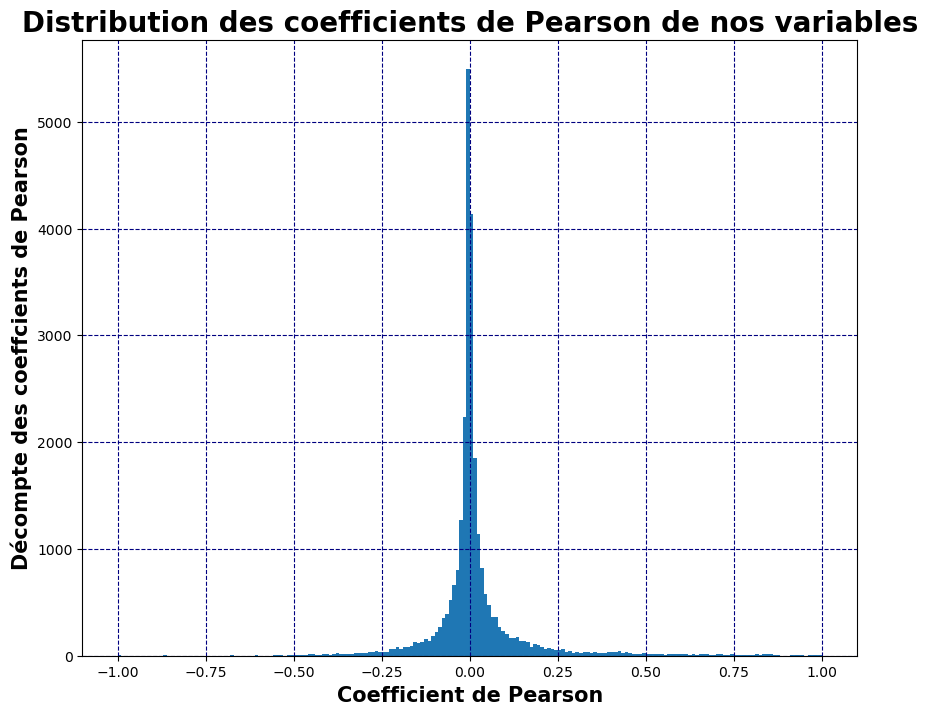

In [19]:
#Coefficients de Pearson des features numériques

fig, Corr_train = correlation_lister(train_num)

In [20]:
#Sélection des features pour limiter les corrélations trop élevées

train_num_cleaned = Correlation_filter(train_num, corr_thresh)

In [21]:
#Suppession des colonnes droppés de train et test

inti_cols = train_num.columns
end_cols = train_num_cleaned.columns
diff = inti_cols.drop(end_cols)

train = train.drop(diff, axis = 1)
test = test[train.columns]

In [22]:
#Décompte des p_values pour le crière du chi2 pour les variables qualitatives de notre jeu de données train

p_values = []
feature_A = []
feature_B = []
n = 0
for i in train_cat.columns:
    n+=1
    for j in train_cat.columns[n:]:
        if (j!=i):
            table = pd.crosstab(train_cat[i], train_cat[j])
            results_test = chi2_contingency(table)
            p_values.append(results_test[1])
            feature_A.append(i)
            feature_B.append(j)

In [23]:
#Mise sous forme de DataFrame

chi2_df = pd.DataFrame({'A' : feature_A, 'B' : feature_B, 'p_values' : p_values})

Text(0, 0.5, 'Décompte')

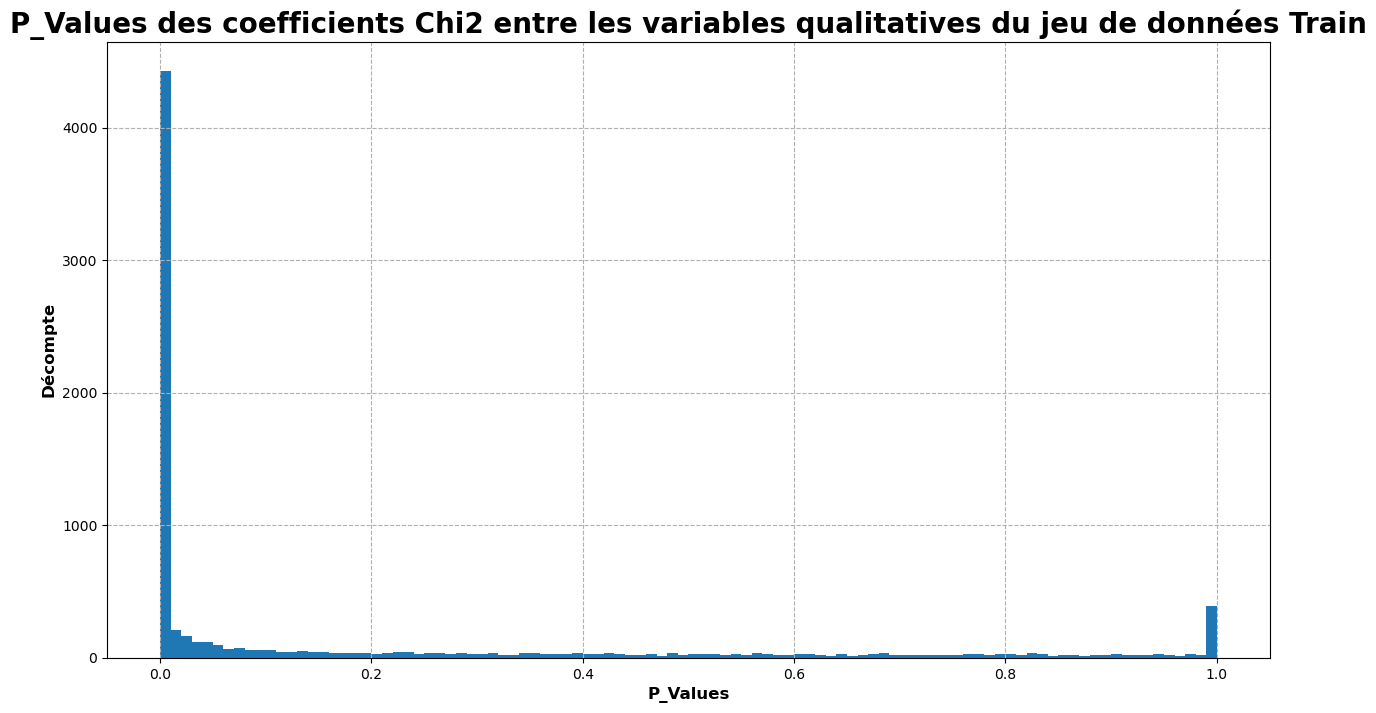

In [24]:
#Affichage de la distribution des p_values

plt.figure(figsize = (15,8))
plt.rcParams.update({'font.size' : 10})
plt.title('P_Values des coefficients Chi2 entre les variables qualitatives du jeu de données Train', size = 20, weight = 'bold')
hist = plt.hist(chi2_df['p_values'], bins = 100)
plt.grid(True, ls = '--')
plt.xlabel('P_Values', size = 12, weight = 'bold')
plt.ylabel('Décompte', size = 12, weight = 'bold')

In [25]:
#Fonction chi2_selector de utils.py - suppression d'un des features trop corrélé

def chi2_selector(df, thresh):
    cat = df.dtypes.loc[df.dtypes == 'object'].index
    categ_df = df[cat]
    p_values = []
    feature_A = []
    feature_B = []
    n = 0
    for i in categ_df.columns:
        n+=1
        for j in categ_df.columns[n:]:
            if (j!=i):
                table = pd.crosstab(categ_df[i], categ_df[j])
                results_test = chi2_contingency(table)
                p_values.append(results_test[1])
                feature_A.append(i)
                feature_B.append(j)
    chi2_df = pd.DataFrame({'A' : feature_A, 'B' : feature_B, 'p_values' : p_values})
    tmp = chi2_df.loc[chi2_df['p_values']>thresh]
    dropped_features = tmp['A'].unique()
    df = df.drop(dropped_features, axis = 1)
    return df

In [26]:
#Sélection des features qualitatifs pour le critère du chi2

train = chi2_selector(train, 0.9)

In [27]:
#Calcul du coefficient eta_squared entre deux features
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    del x, y, moyenne_y, classes
    gc.collect()
    return SCE/SCT

#Fonction du fichier utils.py filtarant les colonnes qualitatives ayant un coefficient eta_squared trop
#élevé avec au mois une colonne quantitative
def eta_squared_selector(df, thresh):
    cat = df.dtypes.loc[df.dtypes == 'object'].index
    categ_df = df[cat]
    num = df.dtypes.loc[df.dtypes != 'object'].index
    num_df = df[num]
    num_cols = []
    cat_cols = []
    eta_squared_list = []
    for i in cat:
        for j in num:
            eta_squared_list.append(eta_squared(df[i], df[j]))
            num_cols.append(j)
            cat_cols.append(i)
    eta_squared_list = np.abs(eta_squared_list)
    concat_df = pd.DataFrame({'Num' : num_cols, 'Cat' : cat_cols, 'eta_sq' : eta_squared_list})
    dropped = concat_df.loc[concat_df['eta_sq']>thresh, 'Cat'].unique()
    df = df.drop(dropped, axis = 1)
    return df

In [28]:
#Suppression des features qualitatifs trop corrélés aux features quantitatifs
#Non réalisé ici car très long sans suppresion de features

#train = eta_squared_selector(train, corr_thresh)

In [29]:
#Synchronisation des colonnes entre train et test

test = test[train.columns]

## 1.5- Mise en mémoire des jeux de données

In [30]:
#Formes des jeux de données

print("Forme du jeu de données d'entraînement : {}".format(train.shape))
print("Forme du jeu de données de production : {}".format(test.shape))
print("Forme du jeu de données targets : {}".format(target.shape))

Forme du jeu de données d'entraînement : (307507, 192)
Forme du jeu de données de production : (48744, 192)
Forme du jeu de données targets : (307507, 1)


In [31]:
#export dans un répertoire temporaire des jeux de donnés au formt .pkl en attendant d'être loggués en artefact et des exp_id au format .json
os.chdir('..')
if pickle_export == True:
    os.chdir('src/preprocessed')
    for i in os.listdir():
        os.remove(i)
    os.chdir('..')
    train.to_pickle('preprocessed/train.pkl')
    test.to_pickle('preprocessed/test.pkl')
    target.to_pickle('preprocessed/target.pkl')
    with open('mlflow_exp/exp_id.json', 'w') as fp:
        json.dump(EXP_DICT, fp)
    os.chdir('..')

## 1.6- Entraînement Dummy Classifier et mesure des métriques

In [32]:
#On se place dans la nouvelle expérience mlflow et séparation des données en train et test - startification sur la target - test size à 0.2
mlflow.set_experiment(exp_name)
Rand_State = 11
Test_Size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify = target, random_state = Rand_State, test_size = Test_Size)

#export dans un répertoire temporaire des jeux de donnés d'entraînement det de test en attendant log mlflow
for i in os.listdir('src/train_test'):
    os.remove('src/train_test/'+i)
X_train.to_pickle('src/train_test/X_train.pkl')
X_test.to_pickle('src/train_test/X_test.pkl')
y_train.to_pickle('src/train_test/y_train.pkl')
y_test.to_pickle('src/train_test/y_test.pkl')

In [33]:
#Importation de time pour mesures des temps d'inférence et de production

import time

In [34]:
#Mise en place Dummy Classifier - strategy most frequent pour coller à un jeu de données à targets déséquilibrées (Bonnes accuracy, mauvais recall)
Dummy = DummyClassifier(strategy='most_frequent')
train_time_start = time.time()
Dummy.fit(X_train, y_train)
train_time = time.time() - train_time_start
inference_time_start = train_time_start = time.time()
Dummy.predict(X_test.iloc[0].values.reshape(1,-1))
inference_time = time.time() - inference_time_start
y_train_pred = Dummy.predict(X_train)
y_test_pred = Dummy.predict(X_test)
print("Temps d'entraînement : {}".format(train_time))
print("Temps d'inférence : {}".format(inference_time))

Temps d'entraînement : 0.01562356948852539
Temps d'inférence : 0.01563096046447754


128

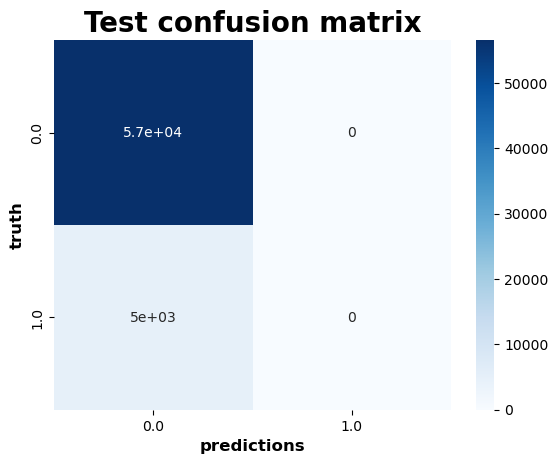

In [35]:
#Mesure des métriqus classiques sur jeux de données train et test
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_rec = recall_score(y_train, y_train_pred)
test_rec = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

#Mesure du score défini
train_score = fn_fp_scorer(y_train, y_train_pred)
test_score = fn_fp_scorer(y_test, y_test_pred)

'''Les confusion matrix et les rocs curves sont enregistrés dans un repértoire tempon en attendant d'étre logguées via mlflow'''
#Création confusion matrix test et export dans le repértoire metrics figure
for i in os.listdir('src/metrics_figures'):
    os.remove('src/metrics_figures/'+i)
test_cm = confusion_matrix(y_test, y_test_pred, labels=Dummy.classes_)
test_cm_df = pd.DataFrame(test_cm, index = Dummy.classes_, columns = Dummy.classes_)
fig_conf_test = sns.heatmap(test_cm_df, annot=True, cmap = 'Blues')
plt.title('Test confusion matrix', size = 20, weight = 'bold')
plt.xlabel('predictions', size = 12, weight = 'bold')
plt.ylabel('truth', size = 12, weight = 'bold')
fig_conf_image_test = fig_conf_test.figure.savefig('src/metrics_figures/test_conf_matrix.png')
del test_cm, test_cm_df, fig_conf_test
gc.collect()

4940

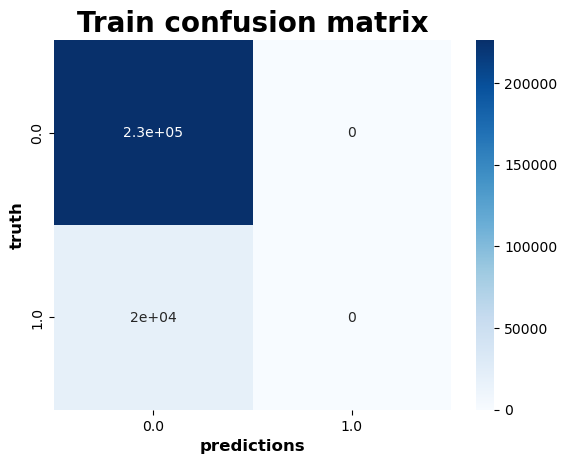

In [36]:
#Création confusion matrix train
train_cm = confusion_matrix(y_train, y_train_pred, labels=Dummy.classes_)
train_cm_df = pd.DataFrame(train_cm, index = Dummy.classes_, columns = Dummy.classes_)
fig_conf_train = sns.heatmap(train_cm_df, annot=True, cmap = 'Blues')
plt.title('Train confusion matrix', size = 20, weight = 'bold')
plt.xlabel('predictions', size = 12, weight = 'bold')
plt.ylabel('truth', size = 12, weight = 'bold')
fig_conf_image_train = fig_conf_train.figure.savefig('src/metrics_figures/train_conf_matrix.png')
del train_cm, train_cm_df, fig_conf_train
gc.collect()

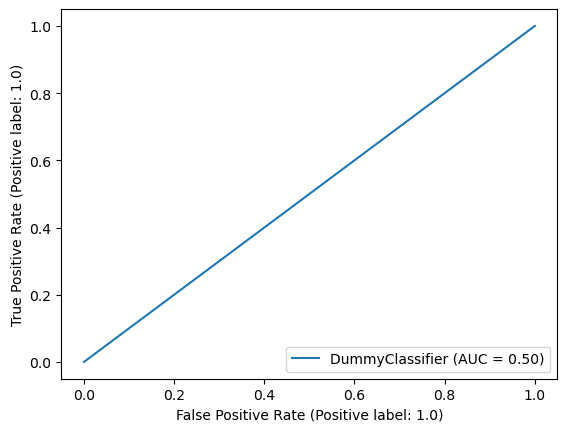

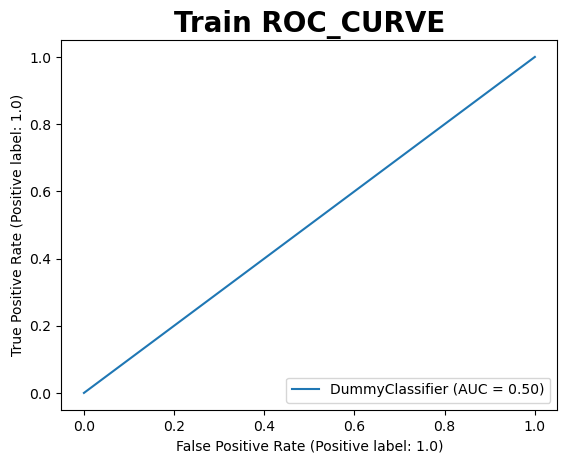

In [37]:
#roc_curve jeu de données train
train_roc_curve = RocCurveDisplay.from_estimator(Dummy, X_train, y_train)
train_roc_curve_plot = train_roc_curve.plot().figure_
plt.title('Train ROC_CURVE', size = 20, weight = 'bold')
train_roc_image = train_roc_curve_plot.savefig('src/metrics_figures/train_roc_curve.png')

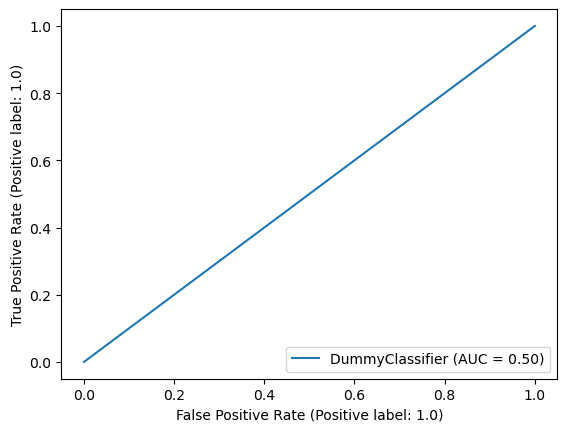

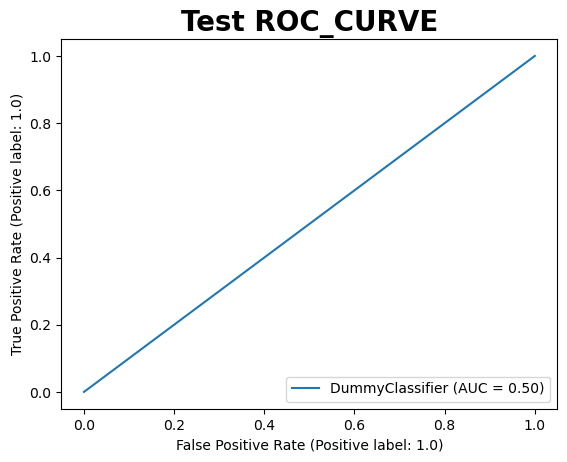

In [38]:
#roc_curve jeu de données test
test_roc_curve = RocCurveDisplay.from_estimator(Dummy, X_test, y_test)
test_roc_curve_plot = test_roc_curve.plot().figure_
plt.title('Test ROC_CURVE', size = 20, weight = 'bold')
test_roc_image = test_roc_curve_plot.savefig('src/metrics_figures/test_roc_curve.png')

## 1.7- Centralisation des résultats et création de la première run MLFLow

In [39]:
#Création de la run mlflow et nom de la run 'DummyClassifier'
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name= 'DummyClassifier', nested=False) as run:
    #Mise en tag du random state du train_test_split et du test size
    mlflow.set_tag('Train_Test_Split_Random_State', str(Rand_State))
    mlflow.set_tag('Test_Size', str(Test_Size))
     #log des jeux de données et des plots roc_curve et confusion_matrix
    mlflow.log_artifacts("src/preprocessed", artifact_path = 'preprocessed')
    mlflow.log_artifacts("src/train_test", artifact_path = 'train_test')
    mlflow.log_artifacts("src/metrics_figures", artifact_path = 'metrics_figures')

    #log des métriques
    mlflow.log_metric('Train_AUC', train_auc)
    mlflow.log_metric('Test_AUC', test_auc)
    mlflow.log_metric('Train_ACC', train_acc)
    mlflow.log_metric('Test_ACC', test_acc)
    mlflow.log_metric('Train_REC', train_rec)
    mlflow.log_metric('Test_REC', test_rec)
    mlflow.log_metric('Train_F1', train_f1)
    mlflow.log_metric('Test_F1', test_f1)
    mlflow.log_metric('Inference_time', inference_time)
    mlflow.log_metric('Training_time', train_time)
    mlflow.log_metric('Train_balanced_ACC', train_balanced_acc)
    mlflow.log_metric('Test_balanced_ACC', test_balanced_acc)
    mlflow.log_metric('Test_custom_score', test_score)
    mlflow.log_metric('Train_custom_score', train_score)

    #log du modèle et récupération de l'id de la run
    mlflow.sklearn.log_model(Dummy, str(EXPERIMENT_NAME) + '_DummyClassifier')
    run_id = run.info.run_id

#Désallocation des variables placées en mémoire à l'utilisation de la fonction
del EXP_DICT, train_index, df, pickle_export
gc.collect()
del Rand_State, Test_Size, X_train, X_test, y_train, y_test, Dummy, y_train_pred, y_test_pred, train_auc, test_auc, train_acc
gc.collect()
del test_acc, train_rec, test_rec, train_f1, test_f1, train_balanced_acc, test_balanced_acc, train_score, test_score, train_roc_curve
gc.collect()
del train_roc_curve_plot, train_roc_image, test_roc_curve, test_roc_curve_plot, test_roc_image
gc.collect()

6252

# 2- Entraînement des modèles - fonction *'hyper_param_tuning'*

## 2.1- Importation des jeux de données

In [41]:
#Importation des données stockées via la fonction pkl_import

train, test, target, exp_id, exp_name = pkl_import()

In [47]:
#Affichage des distribution de la target

target['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

Text(0.75, 150000, '8.07%')

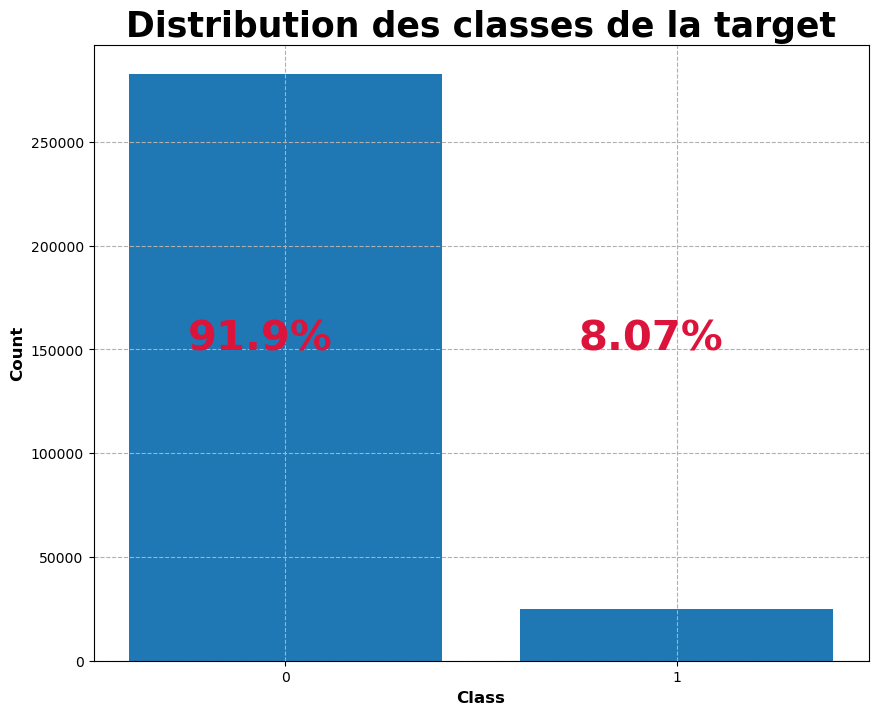

In [62]:
plt.figure(figsize = (10,8))
plt.title("Distribution des classes de la target", size = 25, weight = 'bold')
plt.bar(x = target['TARGET'].value_counts().index, height = target['TARGET'].value_counts().values)
plt.grid(True, ls = '--')
plt.xticks([0,1])
plt.xlabel('Class', size = 12, weight = 'bold')
plt.ylabel('Count', size = 12, weight = 'bold')
plt.text(-0.25, 150000, "{}%".format(str((target['TARGET'].value_counts()[0]/len(target))*100)[:4]), size = 30, weight = 'bold', color = 'crimson')
plt.text(0.75, 150000, "{}%".format(str((target['TARGET'].value_counts()[1]/len(target))*100)[:4]), size = 30, weight = 'bold', color = 'crimson')

In [63]:
#Affichage des poids de chaque classe

from sklearn.utils.class_weight import compute_class_weight

weight_table = compute_class_weight(class_weight = 'balanced', classes = target['TARGET'].unique(), y = target['TARGET'].values)

In [65]:
print('Poids de la classe positive : {}'.format(weight_table[0]))
print('Poids de la classe négative : {}'.format(weight_table[1]))

Poids de la classe positive : 6.1934944612286005
Poids de la classe négative : 0.5439097643288218


## 2.2- Définition des paramètres de la fonction

*NB: Dans notre cas et par manque de ressources computationnelles, la recherche sur grille a été effectuée sur des notebooks brouillons, et une une partie est intégrée directement en hyperparamètres éntrés manuellement.*

In [77]:
#Paramètres de la fonction hyper_param_tuning de la fonction ../src/train.py

#Choix de l'export des meilleurs hyperparamètres - ajout d'un preprocesseur de scaling (composite standardscaler et minmaxscaler) 
#et pas de réduction dimensionnelle
json_export = True
scaler = True
pca_state = False

#Ces hyperparamètres ont été testé par validation croisée sur un notebook brouillon.
params = {'n_estimators' : 100, 'reg_alpha' : 0.8, 'subsample' : 0.2, 'learning_rate' : 0.00005, 'reg_lambda' : 0.5}

#De manière à accélérer le temps de traitement, nous effectuons la recherche sur grille sur les hyperparamètres suivants
grid_params = {'colsample_bytree' : [0.3, 0.5, 0.7]}

#Informations sur l'expéience en cours et choix du nom de la run
model_type = 'LightGBM'
new_run_name = 'LGBM_Class_Weight'
experiment_name = 'PROJECT_7_OC_DS_EXPERIENCE_REFERENCE' 
experiment_id = '166951002022495853'

In [78]:
#Check type des colonnes après importation
for i in train.columns:
    if len(train[i].unique())<3:
        train[i] = train[i].astype(object)
    else:
        train[i] = train[i].astype(float)

#Masks colonnes catégoriques et numériques pour input des préprocesseurs
num_mask = (train.dtypes != object).values
cat_mask = (train.dtypes == object).values

In [79]:
#Séparation des données d'entraînement en un jeu de données d'entraînement et de test
Rand_State = 11
Test_Size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify = target, random_state = Rand_State, test_size = Test_Size)

#Définition des preprocesseurs customisables via l'application (ajout au pipeline ou non)
std = make_column_transformer((StandardScaler(), num_mask), (MinMaxScaler(), cat_mask))
pca = make_column_transformer((PCA(), num_mask), (TruncatedSVD(), cat_mask))

#Définition du classifieur, via la méthode Thresholder de la librairie Sklego. Cela nous permet d'effectuer la recherche du meilleur seuil
#de classification par validation croisée sur le jeu de données d'enraînement, au même titre que les autres hyperparamètres
classifier = Thresholder(LGBMClassifier(**params), threshold = 0.5)

In [80]:
#Nous nous placons dans le cas où l'on applique un préprocesseur composite - StandardSclaer sur les features quantitatifs, et MinMaxSclaer 
#sur les features qualitatifs - Auncune réduction dimensionnelle ici
pipe = Pipeline(steps = [('std', std), ('classifier', classifier)])

#Dans le fichier python, le serveur recoit des paramètres de type float (json serializable), que nous convertissons en type integer ici
for i in grid_params.keys():
    if i in classifier.get_params().keys():
        if type(classifier.get_params()[i]) == int:
            grid_params[i] = np.array(grid_params[i]).astype(int)
param_keys= grid_params.copy().keys()

In [81]:
#Modification des clés du dictionaire de grille des paramètre pour les faire correspondre au pipeline
for i in param_keys:
    grid_params['classifier__model__'+i] = grid_params[i]
for i in param_keys:
    del grid_params[i]
    
#Ajout des seuils de prédiction pour la recherche sur grille
grid_params['classifier__threshold'] = np.linspace(0.1, 0.9, 9)

#Définition du paramètre class_weight pour pénalisation plus forte sur la classe minoritaire
pipe.set_params(**{'classifier__model__class_weight' : 'balanced', 'classifier__threshold' : 0.2})

Pipeline(steps=[('std',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  Tru...
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]))])),
                ('classifier',
                 Thresholder(model=LGBMClassifier(class_weight='balanced',
                                                  learning_rate=5e-05,
                                                  reg_alpha=0.8, reg_lambda=0.5,
                                                  subsample=0.2),
                             threshold=0.2))])

In [82]:
#Définition des métriques de suivi et de la grille puis entraînement
score = {'Self_Score' : model_score, 'F1' : 'f1', 'Recall' : 'recall', 'Accuracy' : 'accuracy', 'ROC_AUC' : 'roc_auc', 'Balanced_Accuracy' : 'balanced_accuracy'}
grid = GridSearchCV(pipe, grid_params, cv = 5, n_jobs= 4, verbose = 3, scoring = score, refit = 'Self_Score')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,...
                                                                         subsample=0.2),
                                                    threshold=0.2))]),
             n_jobs=4,
             param_grid={'classifier__model__colsample_bytree': [0.3, 0.5, 0.7],
                         'classifier__threshold': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             refit='Self_Score',
             scoring={'Accuracy': 'accuracy',
                      'Balanced_Accuracy': 'balanced_accuracy', 'F1': 'f1',
                      'ROC_AUC': 'roc_auc', 'Recall': 'recall',
                      'Self_Score': make_scorer(fn_fp_scorer)},
             verbose=3)

In [84]:
#Affichage des meilleurs hyperparamètres
best_params = grid.best_params_
results = pd.DataFrame(grid.cv_results_)
best_params

{'classifier__model__colsample_bytree': 0.3, 'classifier__threshold': 0.5}

In [143]:
#Visualisation des résultats du gridsearch - cf. app.py fonction import_results

results_viz = results.copy()

results_viz = results_viz.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params'], axis = 1)
for i in results_viz.columns:
    if 'split' in i:
        results_viz = results_viz.drop([i], axis = 1)
    if 'rank' in i:
        results_viz = results_viz.drop([i], axis = 1)
    if 'std_' in i:
        results_viz = results_viz.drop([i], axis = 1)

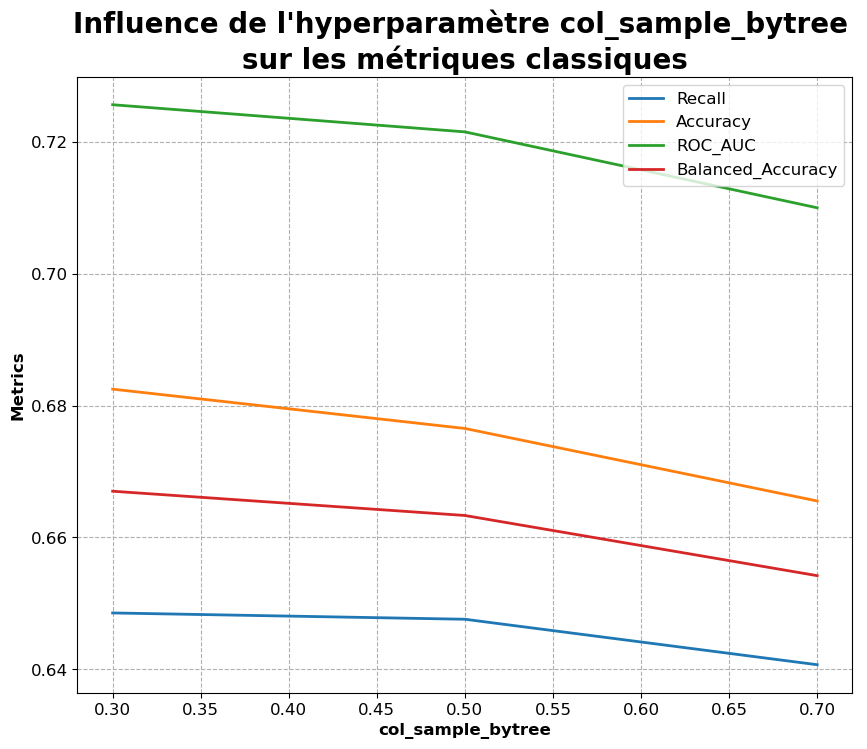

In [160]:
#Influence de l'hyperparamètre col_sample_bytree sur les métriques classiques

results_viz_best_thresh = results_viz.loc[results_viz['param_classifier__threshold'] == best_params['classifier__threshold']]
plt.figure(figsize = (10,8))
for i in list(score.keys())[2:]:
    plt.plot(results_viz_best_thresh['param_classifier__model__colsample_bytree'], results_viz_best_thresh['mean_test_' + i], 
             label = i, lw = 2)
plt.title("Influence de l'hyperparamètre col_sample_bytree \nsur les métriques classiques", size = 20, weight = 'bold')
plt.xlabel("col_sample_bytree", size = 12, weight = 'bold')
plt.ylabel("Metrics", size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.legend(loc = 'upper right')

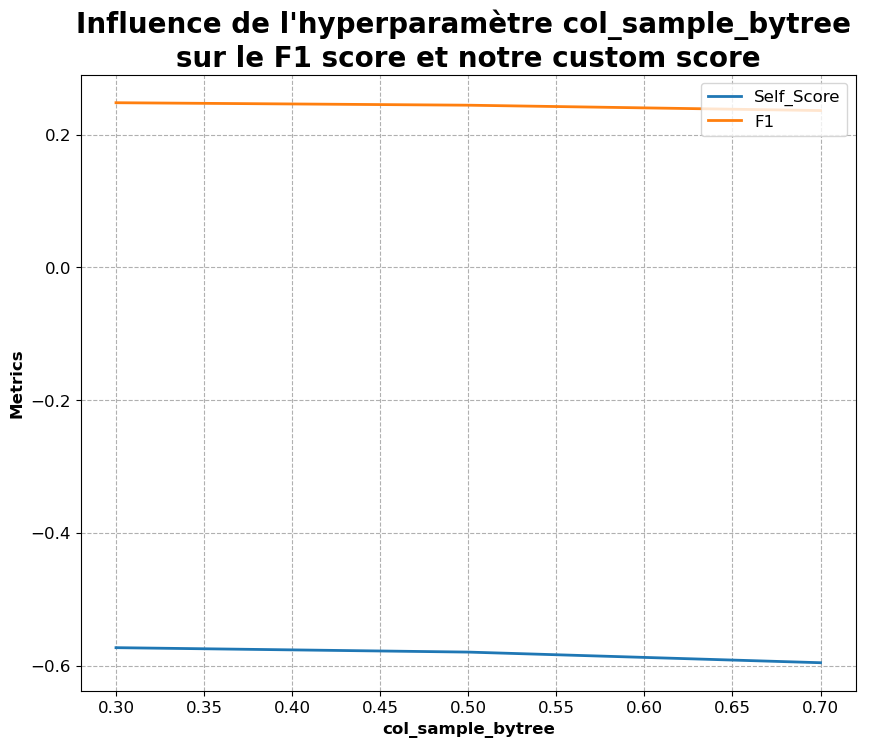

In [161]:
#Influence de l'hyperparamètre col_sample_bytree sur les métriques f1 et le custom score

results_viz_best_thresh = results_viz.loc[results_viz['param_classifier__threshold'] == best_params['classifier__threshold']]
plt.figure(figsize = (10,8))
for i in list(score.keys())[:2]:
    plt.plot(results_viz_best_thresh['param_classifier__model__colsample_bytree'], results_viz_best_thresh['mean_test_' + i], 
             label = i, lw = 2)
plt.title("Influence de l'hyperparamètre col_sample_bytree \nsur le F1 score et notre custom score", size = 20, weight = 'bold')
plt.xlabel("col_sample_bytree", size = 12, weight = 'bold')
plt.ylabel("Metrics", size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.legend(loc = 'upper right')

In [86]:
#Définition nouveau Pipeline, sans le trhesholder

std = make_column_transformer((StandardScaler(), num_mask), (MinMaxScaler(), cat_mask))
classifier = LGBMClassifier(**params)
pipe = Pipeline(steps = [('std', std), ('model', classifier)])

#Définition des paramètres du model
new_params = {}
for i in best_params.keys():
    if 'classifier' in i:
        new_params[i[12:]] = best_params[i]
    elif 'threshold' in i:
        best_threshold = best_params[i]
    else:
        pass

del new_params['threshold']

new_params

{'model__colsample_bytree': 0.3}

In [88]:
#Mise en place des nouveaux hyperparamètre
pipe.set_params(**new_params)
pipe.set_params(**{'model__class_weight' : 'balanced'})

#Entraînement nouveau modèle et mesure des emps d'entraînement et d'inférence
train_time_start = time.time()
pipe.fit(X_train, y_train)
train_time = time.time() - train_time_start

inference_time_start = train_time_start = time.time()
pipe.predict(X_test.iloc[0].values.reshape(1,-1))
inference_time = time.time() - inference_time_start

In [89]:
#Enregistrement des résultats de la recherche sur grille en attendant log mlflow, et des meilleurs hyper-paramètres
if os.path.exists('src/cv_results/results.csv'):
    os.remove('src/cv_results/results.csv')
else:
    pass
results.to_csv('src/cv_results/results.csv', index = False)
param_df = pd.DataFrame(np.array(list(best_params.values())), index = list(best_params.keys())).transpose()
params_float = {}

In [90]:
#Convertion des dtypes en float pour export au format .json - communication client-serveur
for i in best_params.keys():
    try:
        params_float[i] = float(best_params[i])
    except:
        params_float[i] = best_params[i]
if json_export == True:
    os.chdir('src/hyper_params')
    for i in os.listdir():
        os.remove(i)
    os.chdir('../..')
    with open('src/hyper_params/hyperparams.json', 'w') as fp:
        json.dump(params_float, fp)

In [91]:
#Calcul des métriques sur jeu de données d'entraînement et de test

train_proba_predict = pipe.predict_proba(X_train)[:, 1]
test_proba_predict = pipe.predict_proba(X_test)[:,1]
y_train_pred = (train_proba_predict > best_threshold).astype(int)
y_test_pred = (test_proba_predict > best_threshold).astype(int)

train_auc = roc_auc_score(y_train, train_proba_predict)
test_auc = roc_auc_score(y_test, test_proba_predict)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_rec = recall_score(y_train, y_train_pred)
test_rec = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
train_score = fn_fp_scorer(y_train, y_train_pred)
test_score = fn_fp_scorer(y_test, y_test_pred)

In [96]:
#Vérification des métriques pour éviter l'overfitting

print("Train F1 : {}".format(train_f1))
print("Test F1 : {}".format(test_f1))
print("Train Recall : {}".format(train_rec))
print("Test Recall : {}".format(test_rec))
print("Train AUC : {}".format(train_auc))
print("Test AUC : {}".format(test_auc))

Train F1 : 0.253249612343741
Test F1 : 0.24485557136812955
Train Recall : 0.6661127895266868
Test Recall : 0.6410876132930513
Train AUC : 0.7364968372763538
Test AUC : 0.7208225268835793


In [97]:
#Enegistremet des jeux de donénes train et test pour log mlflow
for i in os.listdir('src/train_test'):
    os.remove('src/train_test/'+i)
X_train.to_pickle('src/train_test/X_train.pkl')
X_test.to_pickle('src/train_test/X_test.pkl')
y_train.to_pickle('src/train_test/y_train.pkl')
y_test.to_pickle('src/train_test/y_test.pkl')

In [98]:
#Enregistrement des confusion matrix et des roc_curves pour log mlflow
for i in os.listdir('src/metrics_figures'):
    os.remove('src/metrics_figures/'+i)

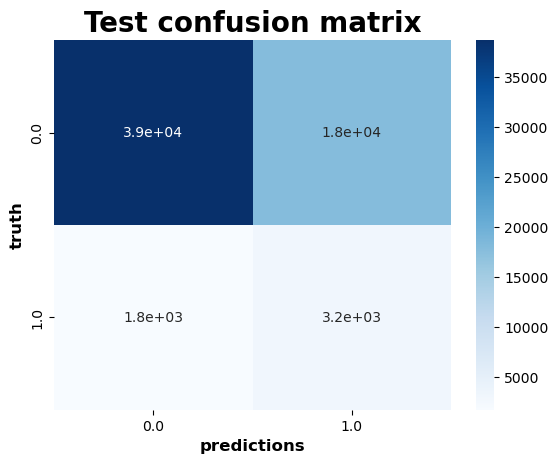

In [99]:
#confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(target['TARGET'].values))
train_cm = confusion_matrix(y_train, y_train_pred, labels=np.unique(target['TARGET'].values))
test_cm_df = pd.DataFrame(test_cm, index = np.unique(target['TARGET'].values), columns = np.unique(target['TARGET'].values))
fig_conf_test = sns.heatmap(test_cm_df, annot=True, cmap = 'Blues')
plt.title('Test confusion matrix', size = 20, weight = 'bold')
plt.xlabel('predictions', size = 12, weight = 'bold')
plt.ylabel('truth', size = 12, weight = 'bold')
fig_conf_image_test = fig_conf_test.figure.savefig('src/metrics_figures/test_conf_matrix.png')

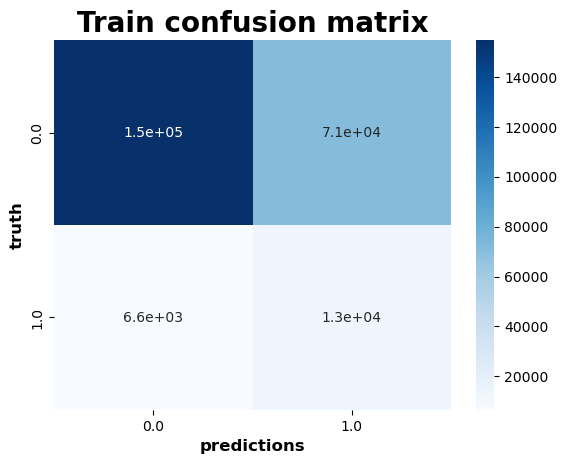

In [100]:
train_cm_df = pd.DataFrame(train_cm, index = np.unique(target['TARGET'].values), columns = np.unique(target['TARGET'].values))
fig_conf_train = sns.heatmap(train_cm_df, annot=True, cmap = 'Blues')
plt.title('Train confusion matrix', size = 20, weight = 'bold')
plt.xlabel('predictions', size = 12, weight = 'bold')
plt.ylabel('truth', size = 12, weight = 'bold')
fig_conf_image_train = fig_conf_train.figure.savefig('src/metrics_figures/train_conf_matrix.png')

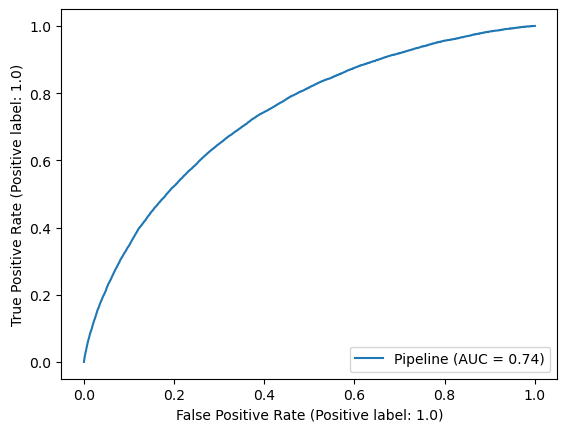

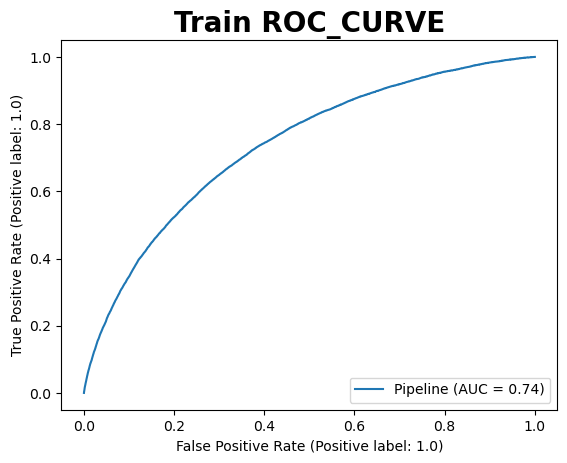

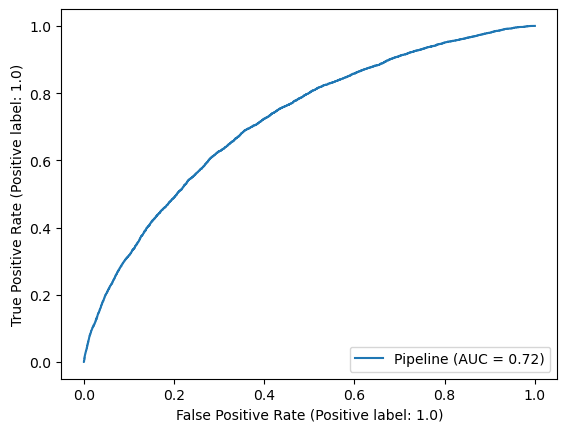

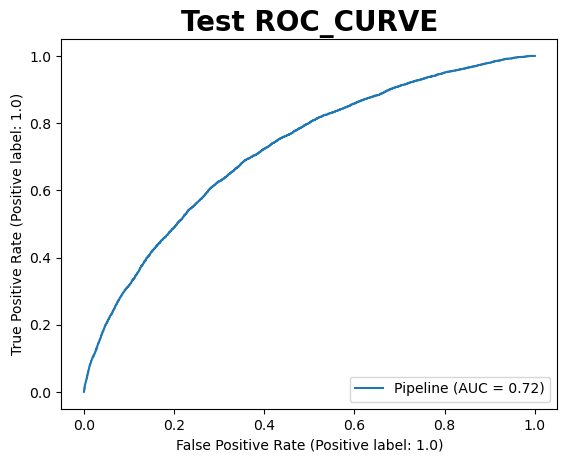

In [101]:
#roc_curve
train_roc_curve = RocCurveDisplay.from_estimator(pipe, X_train, y_train)
train_roc_curve_plot = train_roc_curve.plot().figure_
plt.title('Train ROC_CURVE', size = 20, weight = 'bold')
train_roc_image = train_roc_curve_plot.savefig('src/metrics_figures/train_roc_curve.png')
test_roc_curve = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
test_roc_curve_plot = test_roc_curve.plot().figure_
plt.title('Test ROC_CURVE', size = 20, weight = 'bold')
test_roc_image = test_roc_curve_plot.savefig('src/metrics_figures/test_roc_curve.png')

In [113]:
#Calcul et plot des features importances en fonction des types de modèle -- coefficients de la régression logistique -- fetaure importance pour LGMClasifier
#Pas de feature importnace disponible avec le HistGradientBoostingClassifier -- utilisation de la méthode permutation importance de scikit-learn
if model_type == 'HistGradientBooster':
    feature_importance = permutation_importance(pipe, X_train, y_train, n_repeats=5, random_state=11, n_jobs=1)['importances_mean']
else:
    try:
        feature_importance = pipe['model'].coef_[0]
    except:
        feature_importance = pipe['model'].feature_importances_
features = train.columns
importance = pd.Series(feature_importance, index=features).sort_values(ascending=False)

#Dans le cas de la régression logistique, les coefficients peuvent être négatifs, nous incluons donc une colonne
#en valeurs absolue pour éliminer les features avec les coefficients les plus faibles pour la visualisation
importance_df = pd.DataFrame({'features' : features, 'importance' : feature_importance, 'abs_importance' : np.abs(feature_importance)})

In [132]:
#On se place sur les 15 features avec l'importance la plus forte

importance_df_loc = importance_df.sort_values(by = 'abs_importance', ascending = True).iloc[-15:]
importance_df_loc = importance_df_loc.sort_values(by = 'importance', ascending = True)

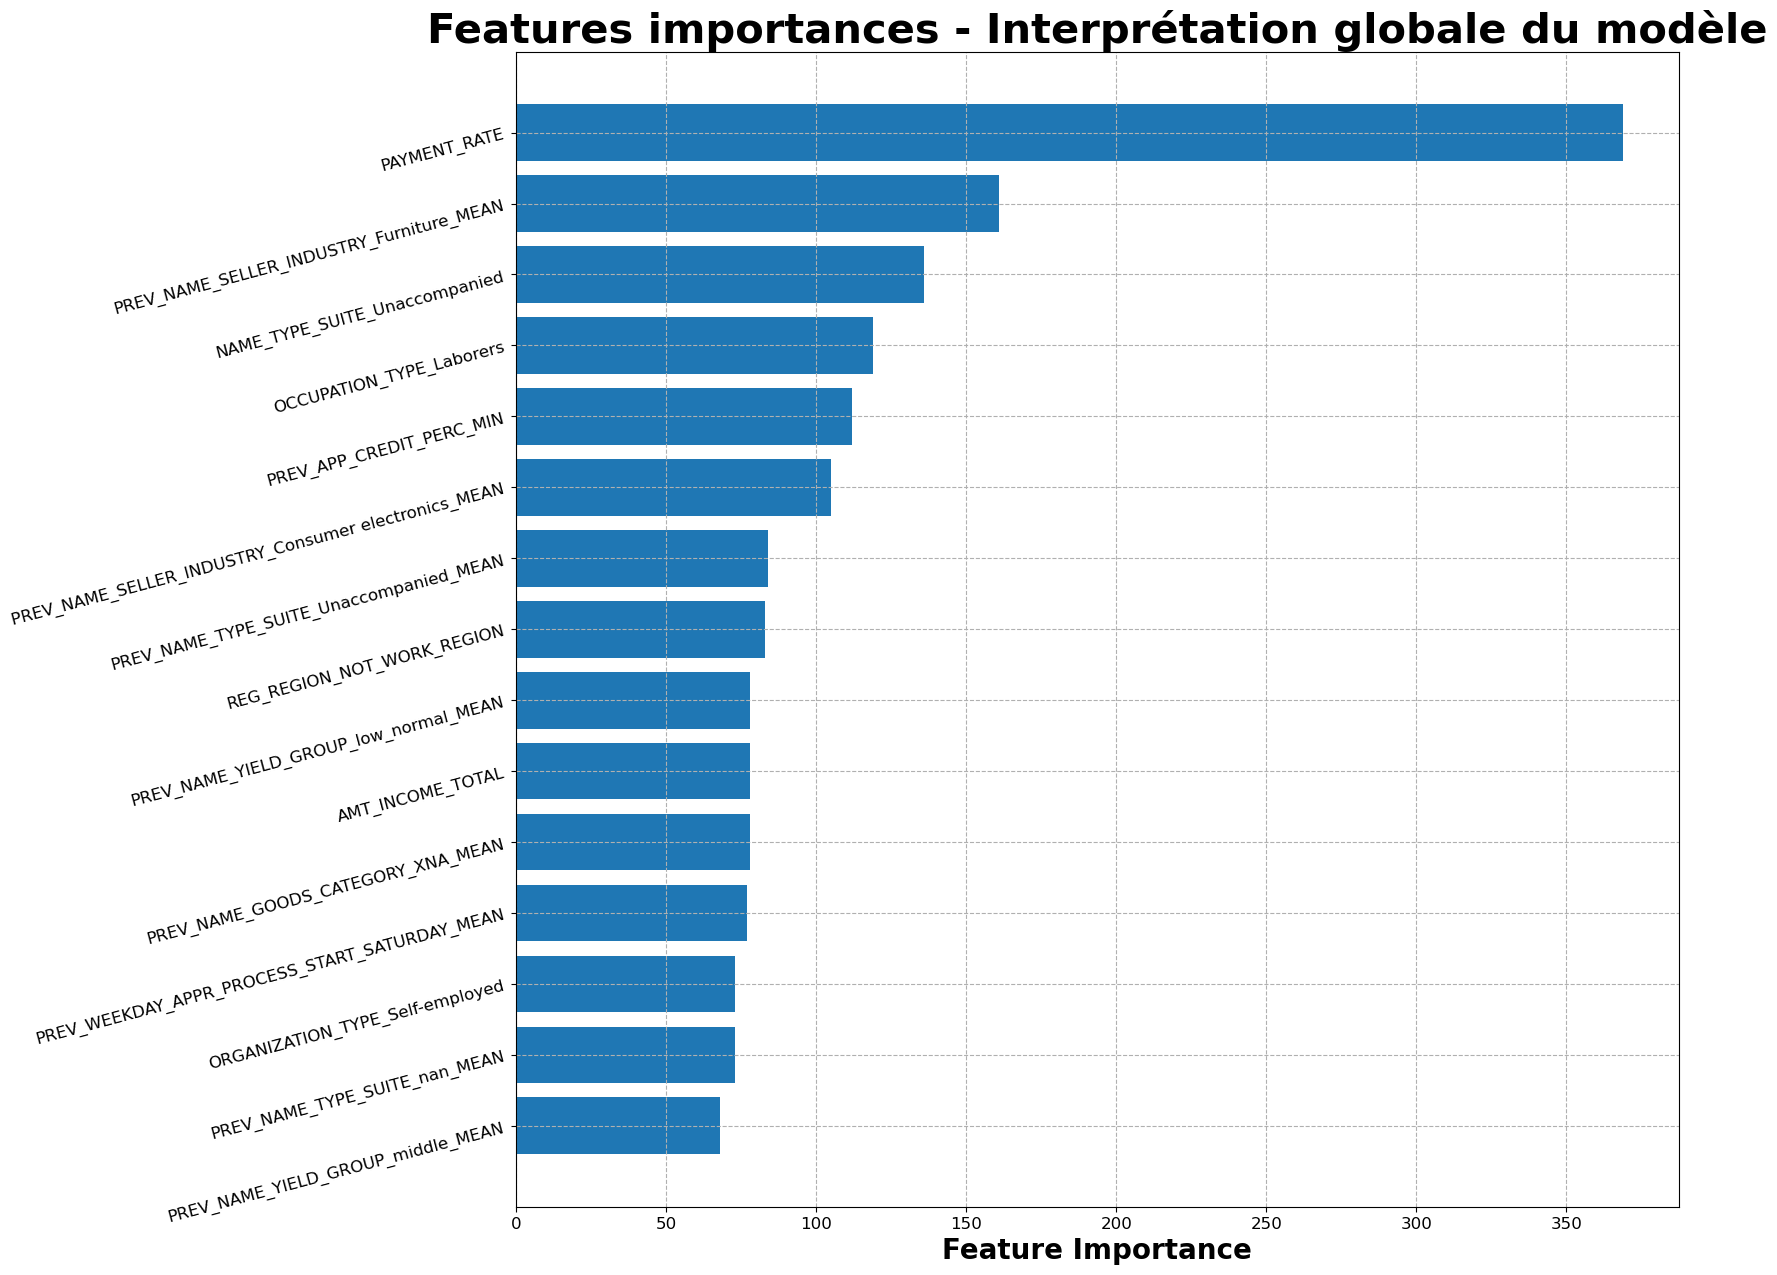

In [138]:
#Affichage des features importances les plus significatives

importance_fig = plt.figure(figsize = (15,15))
plt.rcParams.update({'font.size' : 12})
plt.title('Features importances - Interprétation globale du modèle', size = 30, weight = 'bold')
plt.barh(importance_df_loc['features'].values, importance_df_loc['importance'].values)
plt.grid(True, ls = '--')
plt.xlabel('Feature Importance', size = 20, weight = 'bold')
rot = plt.yticks(rotation = 15)

In [139]:
#Nous sauvegardons ce plot en locale pour le logguer via mlflow plus tard

for i in os.listdir('src/feature_importance'):
    os.remove('src/feature_importance/' + i)
importance_fig.savefig('src/feature_importance/feature_importances.png', bbox_inches='tight')

In [162]:
#Nous pouvons également utiliser la permutation importance dans notre cas, pour comparaison

train_perumtation_importance = pd.DataFrame(permutation_importance(pipe, X_train, y_train, n_repeats=5, random_state=11, n_jobs=1)['importances'])

*NB: Cette opération était à la base prévue dans l'application, mais annulée car très coûteuse en ressources computationnelles.
Nous pouvons néanmoins la montrer ici pour l'exemple.*

In [164]:
#Affichage des permutation features importances sur 5 répétitions

train_perumtation_importance['mean'] = train_perumtation_importance.mean(axis = 1)
train_perumtation_importance['features'] = train.columns
train_perumtation_importance

,0,1,2,3,4,mean,features
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PREV_NAME_GOODS_CATEGORY_Education_MEAN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,POS_NAME_CONTRACT_STATUS_Demand_MEAN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other ...
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PREV_CHANNEL_TYPE_Car dealer_MEAN
...,...,...,...,...,...,...,...
187,-0.000008,0.000024,0.000016,-0.000008,0.000004,0.000006,AMT_INCOME_TOTAL
188,-0.000301,-0.000102,-0.000126,-0.000390,-0.000289,-0.000241,AMT_CREDIT
189,-0.002504,-0.002142,-0.002459,-0.002203,-0.002443,-0.002350,INSTAL_AMT_PAYMENT_SUM
190,-0.000130,-0.000020,0.000033,-0.000118,-0.000081,-0.000063,INSTAL_PAYMENT_PERC_VAR


In [165]:
#Tri  par ordre croissant des features importance

train_perumtation_importance['abs_mean'] = train_perumtation_importance['mean'].abs()
train_perumtation_importance = train_perumtation_importance.sort_values(by = 'abs_mean', ascending = False)
train_perumtation_importance_loc = train_perumtation_importance.iloc[:15]

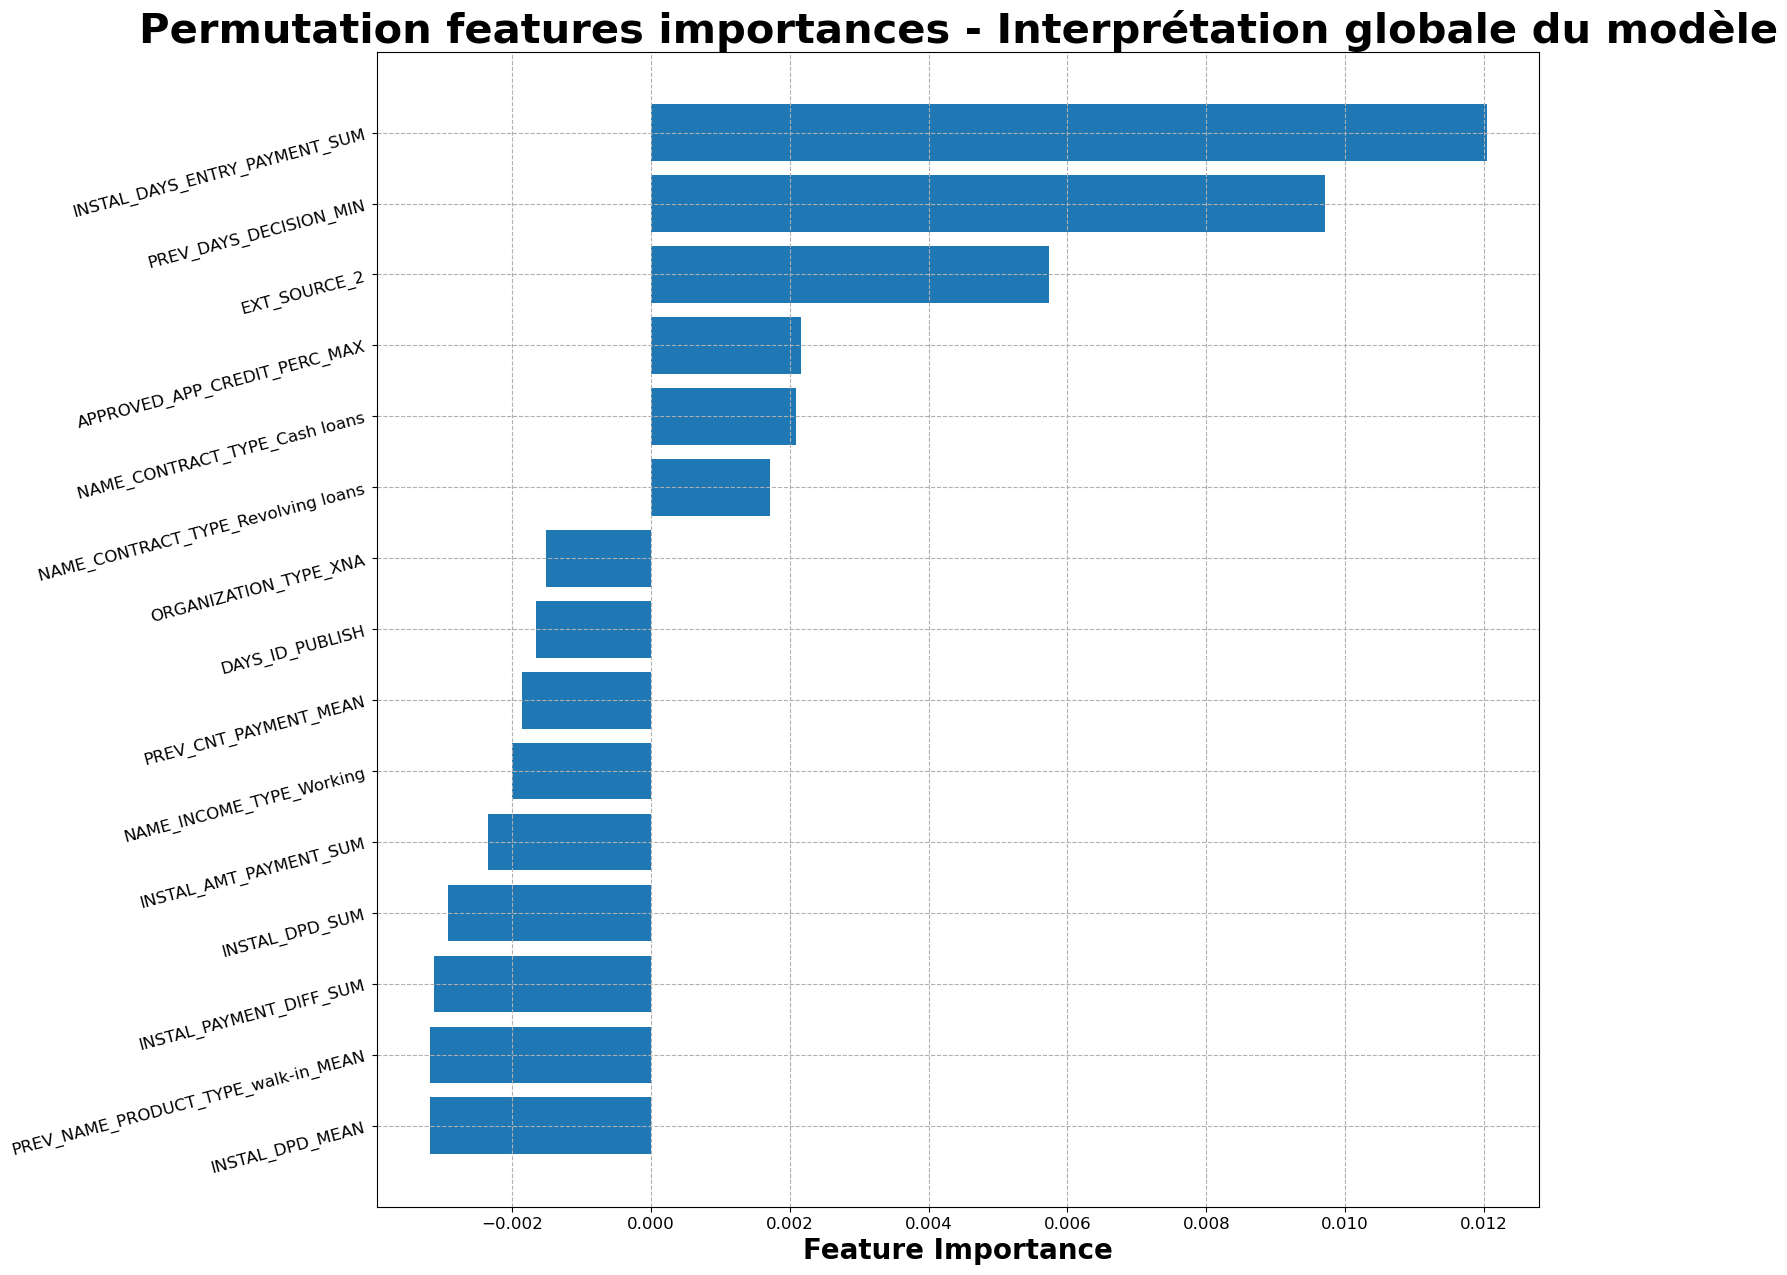

In [169]:
#Affichage des features importances les plus significatives

train_perumtation_importance_loc = train_perumtation_importance_loc.sort_values(by = 'mean', ascending = True)
perm_importance_fig = plt.figure(figsize = (15,15))
plt.rcParams.update({'font.size' : 12})
plt.title('Permutation features importances - Interprétation globale du modèle', size = 30, weight = 'bold')
plt.barh(train_perumtation_importance_loc['features'].values, train_perumtation_importance_loc['mean'].values)
plt.grid(True, ls = '--')
plt.xlabel('Feature Importance', size = 20, weight = 'bold')
rot = plt.yticks(rotation = 15)

*NB : 5 itérations ne sont pas assez pour avoir un résultat répétable, stable et pertinent avec cette méthode.*
*Ici, nous utilisons cette méthode pour illustrer une altérnative à la méthode built-in du modèle.*

In [170]:
#Le nom du modèle est standardisé

with mlflow.start_run(experiment_id=experiment_id, run_name = new_run_name, nested=False) as run:
    mlflow.set_tag('Train_Test_Split_Random_State', str(Rand_State))
    mlflow.set_tag('Test_Size', str(Test_Size))
    mlflow.log_artifacts("src/preprocessed", artifact_path = 'preprocessed')
    run_id = run.info.run_id
    for i in best_params.keys():
        mlflow.log_param(i, best_params[i])
    mlflow.log_metric('Val_score', grid.best_score_)
    mlflow.log_metric('Train_AUC', train_auc)
    mlflow.log_metric('Test_AUC', test_auc)
    mlflow.log_metric('Train_ACC', train_acc)
    mlflow.log_metric('Test_ACC', test_acc)
    mlflow.log_metric('Train_REC', train_rec)
    mlflow.log_metric('Test_REC', test_rec)
    mlflow.log_metric('Train_F1', train_f1)
    mlflow.log_metric('Test_F1', test_f1)
    mlflow.log_metric('Inference_time', inference_time)
    mlflow.log_metric('Training_time', train_time)
    mlflow.log_metric('Train_balanced_ACC', train_balanced_acc)
    mlflow.log_metric('Test_balanced_ACC', test_balanced_acc)
    mlflow.log_metric('Test_custom_score', test_score)
    mlflow.log_metric('Train_custom_score', train_score)
    mlflow.log_artifacts('src/cv_results', artifact_path = "cv_results")
    mlflow.log_artifacts('src/hyper_params', artifact_path = "hyper_params")
    mlflow.log_artifacts("src/train_test", artifact_path = 'train_test')
    mlflow.log_artifacts("src/metrics_figures", artifact_path = 'metrics_figures')
    #mlflow.log_artifacts("src/permutation_importance", artifact_path = 'permutation_importance') - non utilisée
    mlflow.log_artifacts("src/feature_importance", artifact_path = 'feature_importance')
    if model_type == 'LightGBM':
        mlflow.lightgbm.log_model(pipe, experiment_name + '_' + new_run_name + '_' + 'Classifier')
    else:
        mlflow.sklearn.log_model(pipe, experiment_name + '_' + new_run_name + '_' + 'Classifier')

# 3- Entraînement des modèles - fonction *'smote_hyper_param_tuning'*

In [67]:
#Check type des colonnes après importation
for i in train.columns:
    if len(train[i].unique())<3:
        train[i] = train[i].astype(object)
    else:
        train[i] = train[i].astype(float)

In [209]:
#définition du sampling rate

sampling_rate = 2*target['TARGET'].value_counts()[1]/len(target)

In [238]:
#Masks colonnes catégoriques et numériques
num_mask = (train.dtypes != object).values
cat_mask = (train.dtypes == object).values

#Split des jeux de données de train et test
Rand_State = 11
Test_Size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify = target, random_state = Rand_State, test_size = Test_Size)

#Initialisation de SMOTENCODER, avec mask sur les features qualitatifs
smote = SMOTENC(random_state=11, categorical_features=cat_mask, k_neighbors = 3, sampling_strategy = sampling_rate)

*NB: SMOTE utilisant la distance euclidienne pour déterminer les plus proches voisins, il est important de centrer et réduire nos données pour les variables quantitative).*

In [239]:
#Application du resample à notre jeu de données

std = StandardScaler()
X_train_std = std.fit_transform(X_train)

X_train_resampled = smote.fit_resample(X_train_std, y_train)

In [249]:
#Séparation des données initiles et synthétiques

X_train_synth = pd.DataFrame(X_train_resampled[0], columns = X_train.columns).iloc[len(X_train):]
y_train_synth = pd.DataFrame(np.linspace(1, 1, len(X_train_synth)), columns = y_train.columns)

In [251]:
#Réduction dimensionnelle par PCA pour visualisation

pca_2_dims = PCA(n_components=2)
X_train_reduced = pd.DataFrame(pca_2_dims.fit_transform(X_train_std), columns = ['Axe_1', 'Axe_2'])
X_train_synth_reduced = pd.DataFrame(pca_2_dims.transform(X_train_synth), columns = ['Axe_1', 'Axe_2'])

In [252]:
#Ajout des targets à nos jeux de données

X_train_reduced['target'] = y_train['TARGET'].values
X_train_synth_reduced['target'] = y_train_synth['TARGET'].values

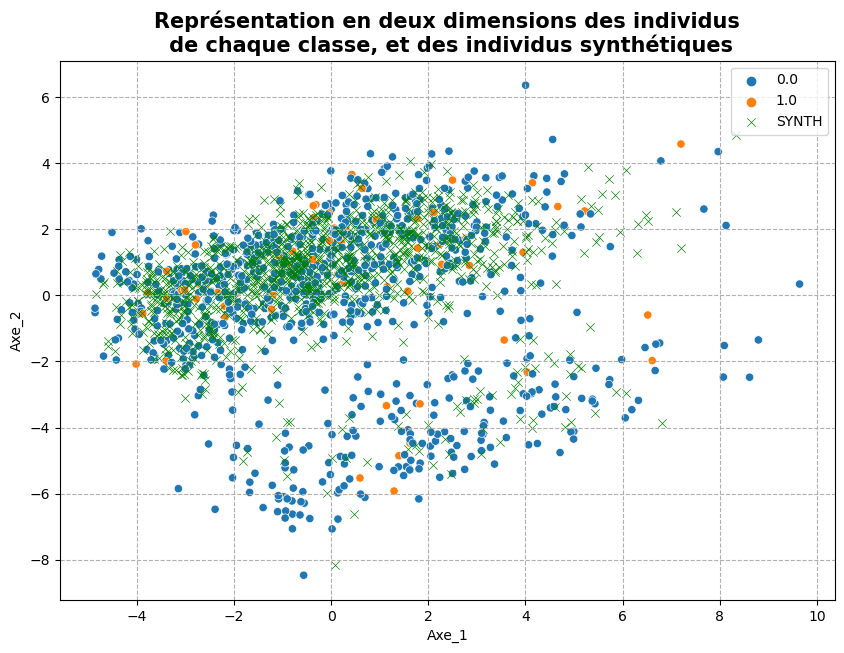

In [253]:
#Visualisation de l'over-sampling SMOTE en 2 dimensions

plt.figure(figsize = (10,7))
plt.title("Représentation en deux dimensions des individus\n de chaque classe, et des individus synthétiques",
         size = 15, weight = 'bold')
sns.scatterplot(data = X_train_reduced.sample(1000), x = 'Axe_1', y = 'Axe_2', hue = 'target', marker = 'o')
sns.scatterplot(data = X_train_synth_reduced.sample(1000), x = 'Axe_1', y = 'Axe_2', c = 'green', marker = 'x', label = 'SYNTH')
plt.grid(True, ls = '--')